## Train and evaluate ML models on satellite image embeddings. 

The grist for this mill are the outputs of [pre-trained deep neural networks](https://github.com/zhu-xlab/SSL4EO-S12), which encode semantic information from satellite imagery of the Earth's surface into 384-dimensional vectors. This notebook facilitates geographic labelling, search of the embedding vectors, and lightweight machine learning with the embedding vectors as inputs. 

**Setup** 
* Install the requirements before launching the notebook:
```
$ python -m venv venv/
$ source venv/bin/activate
$ pip install -r embeddingsML_requirements.txt
$ jupyter notebook
```

**Local dependency** 
* ```ml_utils.py```. Imports from your sys.path.

The local environment has been tested primarily with Python 3.9. 

**Notebook outline** 

* **Embeddings dataframes:** These are the vector outputs of the satellite image foundation model. The code downloads the vector data if needed and loads a couple of versions into GeoDataFrames. The EmbeddingsMapper handles the mapping between latitude / longitude pairs and the corresponding embedding vectors, so we can work with GeoJSON files of lat/lon points. 

* **Labeler:** This is an iPyLeaflet map that allows interactive labeling of positive and negative data samples. It will also display reference data layers.

* **Nearest-neighbor search:** Akin to the Earth Index user interface. Given a few positively and negatively labeled points, it will search the embedding vector space for other similar examples.

* **Training:** Code to or generate GeoJSON sets of positively or negatively labeled lat/lon points, and then to train and evaluate simple ML models. 

* **Run**: Code to run a model or ensemble of models across a whole vector embeddings set.


In [1]:
from datetime import datetime
import json
import os

import annoy
import geopandas as gpd
import ipyleaflet as ipyl
from IPython.display import display
import ipywidgets as ipyw
import joblib
import numpy as np
import pandas as pd

import sys
sys.path.insert(0, '/home/christopher.x.ren/earth-index-ml/demeter/tea')
import ui  # A local dependency. The file ui.py must be found on your sys.path.

%load_ext autoreload
%autoreload 2

# Load config
with open('ui_config.json', 'r') as f:
    config = json.load(f)

parquet_localpath = config['parquet_localpath']
annoy_index_path = config['annoy_index_path']
mgrs_ids = config['mgrs_ids']
start_date = config['start_date']
end_date = config['end_date']
imagery = config['imagery']

gdf = gpd.read_parquet(parquet_localpath)
full_geom = gdf['geometry']
gdf = gdf.drop(columns='tile_id')
gdf['geometry'] = gdf.centroid
embeddings = ui.EmbeddingMapper(gdf)

embedding_dim = len(embeddings.gdf.drop(columns='geometry').columns)
a = annoy.AnnoyIndex(embedding_dim, 'angular')
a.load(annoy_index_path)
print(f"Loaded Annoy index from {annoy_index_path}")


BOUNDARY_PATH = "sumatra_350m_1850m.geojson"
BOUNDARY = gpd.read_file(BOUNDARY_PATH)
maptiler_attribution = '<a href="https://www.maptiler.com/copyright/" target="_blank">&copy; MapTiler</a> <a href="https://www.openstreetmap.org/copyright" target="_blank">&copy; OpenStreetMap contributors</a>'

labeler = ui.GeoLabeler(embeddings.gdf,
                              geojson_path=BOUNDARY_PATH,
                              mgrs_ids=mgrs_ids,
                              start_date=start_date,
                              end_date=end_date,
                              imagery=imagery,
                              baselayer_url=ui.BASEMAP_TILES['MAPTILER'],
                              attribution=maptiler_attribution)


label = ipyw.Label(); display(label)  

def handle_mouse_move(**kwargs):
    lat, lon = kwargs.get('coordinates')
    label.value = f'Lat/lon: {lat:.4f}, {lon:.4f}'

labeler.map.on_interaction(handle_mouse_move)



/tmp/ipykernel_281047/573737923.py:35: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geometry'] = gdf.centroid


Loaded Annoy index from /home/christopher.x.ren/ei-data/test_annoy_file.ann
Initializing GeoLabeler...
Loading RGB composites
Adding controls...


Label(value='')

pos_ids  [1107180]
pos_ids  [1107180, 1103412]
pos_ids  [1107180, 1103412, 1115318]
                           geometry
1110301  POINT (103.17246 -4.04961)
1102167  POINT (103.15374 -4.04378)
1099661  POINT (103.14798 -4.04666)
1105924  POINT (103.16239 -4.04236)
1104037  POINT (103.15804 -4.05537)
...                             ...
1109677  POINT (103.17103 -4.04672)
1105936  POINT (103.16243 -4.02500)
1110311  POINT (103.17249 -4.03515)
1111572  POINT (103.17540 -4.02213)
1102805  POINT (103.15522 -4.02643)

[298 rows x 1 columns]
                           geometry
1719703  POINT (101.27093 -1.80224)
1717829  POINT (101.26661 -1.79646)
1719080  POINT (101.26949 -1.79790)
1718455  POINT (101.26805 -1.79646)
1717825  POINT (101.26662 -1.80225)
...                             ...
1715964  POINT (101.26228 -1.77766)
1705320  POINT (101.23784 -1.78059)
2088353  POINT (101.27097 -1.83551)
1717827  POINT (101.26661 -1.79935)
1715326  POINT (101.26086 -1.79502)

[148 rows x 1 columns]
    

## This cell searches for the nearest neighbors of the query vector

In [5]:


pos_vec = np.mean(embeddings.get_vectors(labeler.pos_ids).values, axis=0)
neg_vec = np.mean(embeddings.get_vectors(labeler.neg_ids).values, axis=0)
query_vec = 2 * pos_vec - neg_vec   # If using positive labels only, set instead: query_vec = pos_vec 
n_nbors = 2000
nbors = a.get_nns_by_vector(query_vec, n_nbors, include_distances=True)
# drop any detections which are in the pos or neg lists
detections = labeler.gdf.loc[nbors[0]].drop(
    labeler.pos_ids, errors='ignore').drop(
        labeler.neg_ids, errors='ignore')
labeler.detection_gdf = detections[['geometry']]
labeler.update_layer(
    labeler.points, json.loads(detections.geometry.to_json()))



#### Hand labeling

Use the map above to label points, then save or reload according to the patterns here.

In [10]:
pos_gdf = labeler.gdf.loc[labeler.pos_ids]
pos_gdf

,vit-dino-patch16_0,vit-dino-patch16_1,vit-dino-patch16_2,vit-dino-patch16_3,vit-dino-patch16_4,vit-dino-patch16_5,vit-dino-patch16_6,vit-dino-patch16_7,vit-dino-patch16_8,vit-dino-patch16_9,...,vit-dino-patch16_375,vit-dino-patch16_376,vit-dino-patch16_377,vit-dino-patch16_378,vit-dino-patch16_379,vit-dino-patch16_380,vit-dino-patch16_381,vit-dino-patch16_382,vit-dino-patch16_383,geometry
1107180,158,111,155,158,106,95,172,112,103,90,...,160,157,104,125,97,78,146,140,132,POINT (103.16529 -4.03658)
1103412,163,109,160,173,98,113,162,136,120,111,...,167,136,112,108,112,77,134,128,166,POINT (103.15660 -4.05392)
1115318,137,101,147,139,129,82,155,111,111,91,...,148,131,85,128,86,65,75,127,160,POINT (103.18402 -4.03662)
1110301,143,91,140,145,115,85,191,110,107,84,...,159,128,88,130,93,70,100,136,175,POINT (103.17246 -4.04961)
1102167,139,123,186,140,111,102,159,127,93,66,...,172,135,128,133,105,97,138,150,127,POINT (103.15374 -4.04378)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1112178,156,135,147,127,132,108,144,98,140,107,...,144,101,119,130,130,76,64,108,114,POINT (103.17678 -4.05107)
1113433,163,90,116,140,127,93,150,108,124,102,...,141,154,93,103,112,57,78,105,128,POINT (103.17967 -4.04674)
1112806,193,130,145,145,116,78,127,108,132,131,...,147,139,101,113,104,47,62,89,138,POINT (103.17823 -4.04818)
1113432,171,107,147,139,122,91,143,116,119,96,...,153,150,111,116,109,47,71,110,139,POINT (103.17967 -4.04818)


In [12]:
neg_gdf

,geometry,id
1111544,POINT (103.17531 -4.06264),1111544
1119692,POINT (103.19407 -4.04822),1119692
1114708,POINT (103.18263 -4.01347),1114708
1087119,POINT (103.11909 -4.07843),1087119
1299045,POINT (98.50769 2.74013),1299045
...,...,...
1315450,POINT (98.54505 2.92687),1315450
1315448,POINT (98.54505 2.92397),1315448
1316077,POINT (98.54648 2.92832),1316077
1315451,POINT (98.54504 2.92832),1315451


In [13]:
DATA_PATH = "/home/christopher.x.ren/ei-data"
sampling_dir = os.path.join(DATA_PATH, 'tea', 'sampling_data')
if not os.path.exists(sampling_dir):
    os.makedirs(sampling_dir, exist_ok=True)
if not os.path.exists(sampling_dir):
    os.mkdir(sampling_dir)

now = datetime.today().isoformat()[:16]
cls = 'pos'
pos_gdf = labeler.gdf.loc[labeler.pos_ids][['geometry']]
pos_gdf['id'] = labeler.pos_ids
pos_gdf.to_file(os.path.join(DATA_PATH, 'tea', f'sampling_data/{cls}-sampled{now}.geojson'))
cls = 'neg'
neg_gdf = labeler.gdf.loc[labeler.neg_ids][['geometry']]
neg_gdf['id'] = labeler.neg_ids
neg_gdf.to_file(os.path.join(DATA_PATH, 'tea', f'sampling_data/{cls}-sampled{now}.geojson'))


### Training

#### Training data

In [17]:
pos_files = ['sampling_data/pos-sampled2024-10-28T21:59.geojson']
pos = pd.concat([gpd.read_file(os.path.join(DATA_PATH, f)) for f in pos_files])

# Note: it's essential not to use points from outside the embeddings AOI
pos = gpd.clip(pos, BOUNDARY)
pos = pos.drop(columns=[c for c in pos.columns if c != 'geometry'])

pos['int_class'] = 1
pos

,geometry,int_class
256,POINT (103.14938 -4.06258),1
125,POINT (103.15947 -4.06116),1
157,POINT (103.15803 -4.06115),1
84,POINT (103.15659 -4.06115),1
278,POINT (103.15226 -4.06114),1
...,...,...
925,POINT (98.86323 2.87195),1
958,POINT (98.86467 2.87195),1
913,POINT (98.88626 2.89077),1
962,POINT (98.88770 2.89077),1


##### One time: randomly sample points from the embeddings dataframe to build a negative dataset. This technique assumes that target objects are sparse geographically and allows a measure of noise in the dataset.

In [18]:
state = 'NB'
cls = 'neg'
n = 1000
neg = gdf.sample(n=n, random_state=42)

In [ ]:
# Optional: clean up random samples which lie within known positive objects:
known_polys = gpd.read_file(os.path.join(DATA_PATH, 'inference/NB_rectpolys2024-05-01.geojson'))
joined = gpd.sjoin(known_polys, neg, how="inner", op="within")
print(len(joined))
#joined.geometry.to_file('~/Desktop/RandomPtsWithinKnownFeedlots.geojson')  # For evaluation in QGIS

In [19]:
neg = neg.drop(joined.index)
neg

NameError: name 'joined' is not defined

In [20]:
now = datetime.today().isoformat()[:16]
neg.geometry.to_file(os.path.join(DATA_PATH, f'sampling_data/{state}{cls}-random{n}_{now}.geojson'))

##### Reload and merge pos/neg labeled datasets

In [25]:
neg_files = ['sampling_data/NBneg-random1000_2024-10-28T22:03.geojson']
neg = pd.concat([gpd.read_file(os.path.join(DATA_PATH, f)) for f in neg_files])

neg['int_class'] = 0
neg

,geometry,int_class
0,POINT (103.95677 -3.78616),0
1,POINT (102.42485 -4.06637),0
2,POINT (101.61936 -1.08453),0
3,POINT (102.95851 -4.33408),0
4,POINT (103.06250 -2.91081),0
...,...,...
995,POINT (98.57644 3.59562),0
996,POINT (101.65157 -1.63543),0
997,POINT (98.84885 2.75614),0
998,POINT (98.43705 2.95866),0


In [26]:
# Consider replicating or subsampling pos or neg sets for class balance 
#training_points = pd.concat([pos, pos, neg])
training_points = pd.concat([pos, neg])

In [27]:
training_points['embedding_idx'] = embeddings.map_points(training_points)
train, val = train_test_split(training_points, train_size=0.8, random_state=42)
display(train.int_class.value_counts())
train_X = embeddings.get_vectors(train['embedding_idx'])
train_Y = train['int_class']

int_class
1    801
0    794
Name: count, dtype: int64

In [73]:
gdf

,vit-dino-patch16_0,vit-dino-patch16_1,vit-dino-patch16_2,vit-dino-patch16_3,vit-dino-patch16_4,vit-dino-patch16_5,vit-dino-patch16_6,vit-dino-patch16_7,vit-dino-patch16_8,vit-dino-patch16_9,...,vit-dino-patch16_375,vit-dino-patch16_376,vit-dino-patch16_377,vit-dino-patch16_378,vit-dino-patch16_379,vit-dino-patch16_380,vit-dino-patch16_381,vit-dino-patch16_382,vit-dino-patch16_383,geometry
0,118,105,121,159,172,103,149,108,143,113,...,125,134,86,121,82,121,85,141,152,POINT (103.19737 -4.52132)
1,145,100,129,165,162,91,135,89,123,125,...,127,132,112,133,93,116,90,157,117,POINT (103.19738 -4.51987)
2,140,82,99,166,144,77,161,93,118,139,...,121,125,108,127,90,118,108,144,123,POINT (103.19738 -4.51842)
3,129,88,120,152,131,74,165,108,118,139,...,121,139,80,129,73,111,106,131,150,POINT (103.19738 -4.51698)
4,138,81,124,156,129,67,130,116,119,146,...,136,142,117,135,88,97,101,128,125,POINT (103.19739 -4.51553)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273664,138,98,71,159,111,123,142,118,148,177,...,154,81,168,133,86,93,81,142,110,POINT (101.69637 -1.81323)
2273665,141,85,77,164,114,122,137,117,136,186,...,147,64,169,123,90,93,89,133,109,POINT (101.69636 -1.81178)
2273666,148,79,67,186,88,130,128,122,129,206,...,135,110,191,108,90,103,108,143,100,POINT (101.69636 -1.81033)
2273667,149,77,65,189,64,142,115,134,126,209,...,115,131,194,117,106,107,113,147,94,POINT (101.69636 -1.80889)


#### Model

In [33]:
from sklearn.ensemble import RandomForestClassifier
# Either instantiate a new model:
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=6,
    random_state=42,
    verbose=1
)
#model = LogisticRegression(max_iter=1000)
# Or reload saved model:
# model_basepath = 'models/RF_2024-07-16T14:53.joblib'
# if os.path.exists(os.path.join(DATA_PATH, model_basepath)):
#     model = joblib.load(os.path.join(DATA_PATH, model_basepath))

model.fit(train_X, train_Y)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s


RandomForestClassifier(max_depth=6, random_state=42, verbose=1)

#### Validation

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

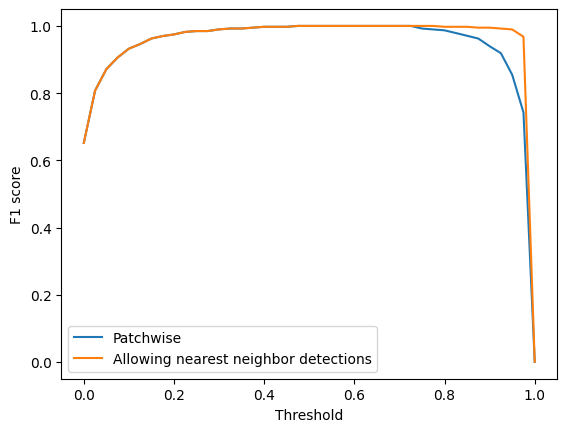

In [34]:
f1, _ = ui.f1_curve(val, embeddings, model)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

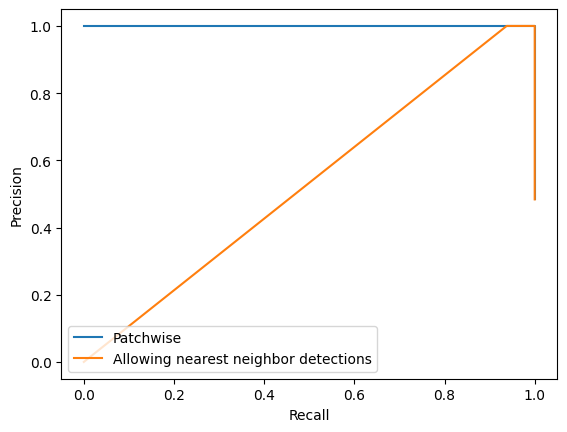

In [35]:
pr, _ = ui.prec_rec_curve(val, embeddings, model)

In [36]:
# Pick a threshold with reference to the F1 curve above, perhaps the rightmost edge of the central plateau.
# (requires some trial and error)
threshold = 0.95
val_Y = val['int_class']
probs, y_pred = ui.predict_df(val, embeddings, model, threshold=threshold)
scores = ui.score(y_pred, val_Y)

accuracy: 0.8771929824561403
precision: 1.0
recall: 0.7461139896373057
confusion: [[206   0]
 [ 49 144]]


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [37]:
# Alternate metrics counting a success with a detection at a nearest neighbor of a positive patch.
_, nbhd_pred = ui.predict_w_nbors(val, embeddings, model, threshold=threshold)
nbhd_scores = ui.score(nbhd_pred, val_Y)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

accuracy: 0.9899749373433584
precision: 1.0
recall: 0.9792746113989638
confusion: [[206   0]
 [  4 189]]


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

In [ ]:
model_dir = os.path.join(DATA_PATH, 'models')
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

now = datetime.today().isoformat()[:16]
model_path = os.path.join(DATA_PATH, f'models/MLP{"-".join([str(s) for s in layer_sizes])}_{now}.joblib')
print(f'Model saved to: {model_path}')
joblib.dump(model, model_path)

output_specs = {
    'inputs': pos_files + neg_files, 
    'threshold': str(threshold), 
    'scores': scores, 
    'nbhd_scores': nbhd_scores
}

with open(model_path.split('.joblib')[0] + '_specs.json', 'w') as f:
    json.dump(output_specs, f, indent=4)

In [ ]:
# Optional save of evaluation curves:
f1.savefig(model_path.split('.joblib')[0] + '_F1.png')
pr.savefig(model_path.split('.joblib')[0] + '_PR.png')

### Run

#### Compute on all points in a region

Attn: for ~10M embeddings (vector dim 384), this pushes RAM limits on a 32 GB laptop. Restarting the kernel and rerunning usually works after a crash.

When restarting, load the embeddings dataframes and then skip to here. 

In [38]:
inference_dir = os.path.join(DATA_PATH, 'inference')
if not os.path.exists(inference_dir):
    os.mkdir(inference_dir)

In [ ]:
# Optionally reload a saved model:
model_basepath = 'models/MLP64-16_2024-07-16T14:53.joblib'
model = joblib.load(os.path.join(DATA_PATH, model_basepath))

In [58]:
threshold = 0.6  # Adjust this according to your determination above
detections = ui.get_detections(embeddings, model, threshold=threshold)
len(detections)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.1s
/home/christopher.x.ren/miniconda/envs/embeddings-nb/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


8460

In [ ]:
# Generally I prefer output polygons, but the point detections make for a smaller file, so sometimes useful: 
#detections.to_file(os.path.join(DATA_PATH, f'inference/detections_Thresh{threshold}{os.path.basename(model_basepath)}.geojson'))

In [77]:
detections.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [78]:
detections.to_file("test_points.geojson")

In [59]:
polys = ui.detections_to_rectpolys(full_geom, detections)
polys

/home/christopher.x.ren/earth-index-ml/demeter/tea/ui.py:493: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polys = patches.buffer(buffer_width, join_style=2).unary_union


,geometry,confidence
0,"POLYGON ((98.30475 2.71397, 98.30475 2.71397, ...",0.610288
1,"POLYGON ((98.30619 2.71397, 98.30619 2.71397, ...",0.775131
2,"POLYGON ((98.30763 2.71397, 98.30763 2.71397, ...",0.729612
3,"POLYGON ((98.30619 2.71542, 98.30619 2.71542, ...",0.667933
4,"POLYGON ((98.39831 2.71547, 98.39831 2.71547, ...",0.731639
...,...,...
8430,POLYGON EMPTY,NaN
8431,POLYGON EMPTY,NaN
8432,POLYGON EMPTY,NaN
8433,POLYGON EMPTY,NaN


In [68]:
gpd.GeoDataFrame(polys).set_crs(epsg=4326).to_file(os.path.join(
    DATA_PATH, f'inference/dev_test_rf.geojson'))

In [63]:
polys.to_file(os.path.join(
    DATA_PATH, f'inference/dev_test_rf.geojson'))

In [ ]:
# Add to map if so desired - but probably better viewed in QGIS at this point
labeler.update_layer(labeler.points, json.loads(detections.geometry.to_json()))

In [ ]:
# Clear map
labeler.update_layer(labeler.points, {})

#### Ensembling models

To run this after a restart, you need only to run the 'Begin notebook' and the 'Embedding dataframe' sections.

In [ ]:
date = '2024-07-16'

# Relax somewhat the single-model thresholds, because you will rethreshold later:
models = {
    'models/MLP64-16_2024-05-15T17:04.joblib': .95, 
    'models/MLP64-16_2024-05-16T14:40.joblib': .95,
    'models/MLP64-16_2024-05-16T15:41.joblib': .95   # Note it's just coincidence that these 3 models share a threshold
}

ensemble_dets = []
for path, threshold in models.items():
    model = joblib.load(os.path.join(DATA_PATH, path))
    detections = ml_utils.get_detections(embeddings, model, threshold=threshold, boundary_path=BOUNDARY_PATH)
    print(len(detections))
    ensemble_dets.append(detections)

In [ ]:
dets = pd.concat(ensemble_dets).drop(columns=['level_0'])

In [ ]:
# Group for voting
# Check for no counts over 3, which would indicate duplicate embedding patches
grouped = dets.groupby(by='geometry').agg(['count', 'mean']).reset_index()
grouped.probability['count'].value_counts()

In [ ]:
req_votes = 3
voted = grouped[grouped.probability['count'] >= req_votes]
voted = gpd.GeoDataFrame(voted, geometry=voted.geometry)

probs = voted.apply(lambda x: x['probability']['mean'], axis=1)
voted = voted.drop(columns='probability')
voted['probability'] = probs

indices = voted.apply(lambda x: int(x['index']['mean']), axis=1)
voted = voted.drop(columns='index')
voted['index'] = indices
voted

In [ ]:
voted_polys = ml_utils.detections_to_rectpolys(full_geom, voted)
display(voted_polys)

In [ ]:
ensemble_output_path = os.path.join(DATA_PATH, f'inference/rectpolysEnsemble_Voted{req_votes}of{len(models)}models{date}.geojson')
voted_polys.to_file(ensemble_output_path)

with open(ensemble_output_path.split('.geojson')[0] + '_models.json', 'w') as f:
    json.dump(models, f, indent=4)

#### Alt ensembling: group for thresholding on mean probability

In [ ]:
grouped = dets.groupby(by='geometry').mean().reset_index()
grouped['index'] = grouped['index'].astype('int')
grouped

In [ ]:
for t in np.arange(.95, 1.00, .005):
    print(f'{t}: {len(grouped[grouped.probability > t])}')

In [ ]:
threshold = .995
thresholded = grouped[grouped.probability > threshold]
thresholded = gpd.GeoDataFrame(thresholded, geometry=grouped.geometry)
display(thresholded)

In [ ]:
thresh_polys = ml_utils.detections_to_rectpolys(full_geom, thresholded)
thresh_polys

In [ ]:
ensemble_output_path = os.path.join(DATA_PATH, f'inference/rectpolysEnsemble_Thresh{threshold}of{len(models)}models{date}.geojson')

thresh_polys.to_file(ensemble_output_path)

with open(ensemble_output_path.split('.geojson')[0] + '_models.json', 'w') as f:
    json.dump(models, f, indent=4)